In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#Because this dataframe involves comma separated values, we used the appropriate read function.
apple <- read_csv("data/apple_quality.csv") |>
    head(-1) #This function removes the last row of the dataframe which included NA values and text crediting the author.
apple

Rows: 4001 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Acidity, Quality
dbl (7): A_id, Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,-3.9700485,-2.512336,5.346330,-1.0120087,1.8449004,0.32983980,-0.491590483,good
1,-1.1952172,-2.839257,3.664059,1.5882323,0.8532858,0.86753008,-0.722809367,good
2,-0.2920239,-1.351282,-1.738429,-0.3426159,2.8386355,-0.03803333,2.621636473,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3997,-2.6345153,-2.138247,-2.4404613,0.6572229,2.199709,4.7638592,-1.334611391,bad
3998,-4.0080037,-1.779337,2.3663970,-0.2003294,2.161435,0.2144884,-2.229719806,good
3999,0.2785397,-1.715505,0.1212173,-1.1540748,1.266677,-0.7765715,1.599796456,good


### Cleaning up the Data ###

As seen above, we have read the csv file in which the data is located in. However, the data contains a lot of columns that we will not be using. To make things tidier, we clean up the data and only select specific columns that we will be using for classification model.

BONUS: We noticed that R had trouble reading the original "Acidity" column. This was most likely because there where hidden characters in the file that R could not read, so below we cleaned up the data with the following code.

In [3]:
apple_manipulated <- apple |>
    clean_names() |>
    mutate(acidity = as.numeric(acidity))
apple_manipulated

a_id,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,-3.9700485,-2.512336,5.346330,-1.0120087,1.8449004,0.32983980,-0.4915905,good
1,-1.1952172,-2.839257,3.664059,1.5882323,0.8532858,0.86753008,-0.7228094,good
2,-0.2920239,-1.351282,-1.738429,-0.3426159,2.8386355,-0.03803333,2.6216365,bad
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3997,-2.6345153,-2.138247,-2.4404613,0.6572229,2.199709,4.7638592,-1.334611,bad
3998,-4.0080037,-1.779337,2.3663970,-0.2003294,2.161435,0.2144884,-2.229720,good
3999,0.2785397,-1.715505,0.1212173,-1.1540748,1.266677,-0.7765715,1.599796,good


In [4]:
set.seed(4321)
#We selected the values we would use for our data analysis, which only included Ripeness, Acidity, and Quality.
#A random sample of 100 was taken because the data set was so large.
apple_select <- apple_manipulated |>
    select(ripeness, acidity, quality)
apple_select

ripeness,acidity,quality
<dbl>,<dbl>,<chr>
0.32983980,-0.4915905,good
0.86753008,-0.7228094,good
-0.03803333,2.6216365,bad
⋮,⋮,⋮
4.7638592,-1.334611,bad
0.2144884,-2.229720,good
-0.7765715,1.599796,good


### Unknown K Value ###

When solving classification problems, it is always good to have a defined K value for th model to use. In this case, we do not have the ideal K value yet which is why we created a model to determine candidates for a K value that would yield the best possible predictions within a certain sequence.

In [5]:
set.seed(4321)

apple_split <- initial_split(apple_select, prop = 0.75, strata = quality)
apple_train <- training(apple_split)
apple_test <- testing(apple_split)

apple_recipe <- recipe(quality ~ ripeness + acidity, data = apple_train) |>
 step_scale(all_predictors())|>
 step_center(all_predictors())

apple_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

apple_workflow <- workflow() |>
    add_recipe(apple_recipe) |>
    add_model(apple_spec) 

apple_vfold<- vfold_cv(apple_train, v=5, strata=quality)

gridvals <- tibble(neighbors=seq(1,20))

apple_results <- apple_workflow |>
 tune_grid(resamples = apple_vfold, grid = gridvals) |>
 collect_metrics() 

apple_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5409962,5,0.005382947,Preprocessor1_Model01
1,roc_auc,binary,0.5409792,5,0.005362711,Preprocessor1_Model01
2,accuracy,binary,0.5409962,5,0.005382947,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,binary,0.6471332,5,0.01349593,Preprocessor1_Model19
20,accuracy,binary,0.5999963,5,0.01321200,Preprocessor1_Model20
20,roc_auc,binary,0.6494338,5,0.01239439,Preprocessor1_Model20


### Determining the Right K Value ###

Based on visualization of potential K values, we determined that the ideal value for K would be ranging from 11-12 (based on a sequence from 1 to 20). This is because it has one of highest accuracies amongst all the potential values of K, which plays well into the cross-validation, because we use cross-validation to determine how a model would perform on a completely different set of data. By doing this, we can determine how the model generalizes predictions and choosing a K with a high accuracy is important especially in the area of generalization where being close to the actual observation is ideal under all possible circumstances and data combinations.

In this case, we will settle with a K value of 11. 

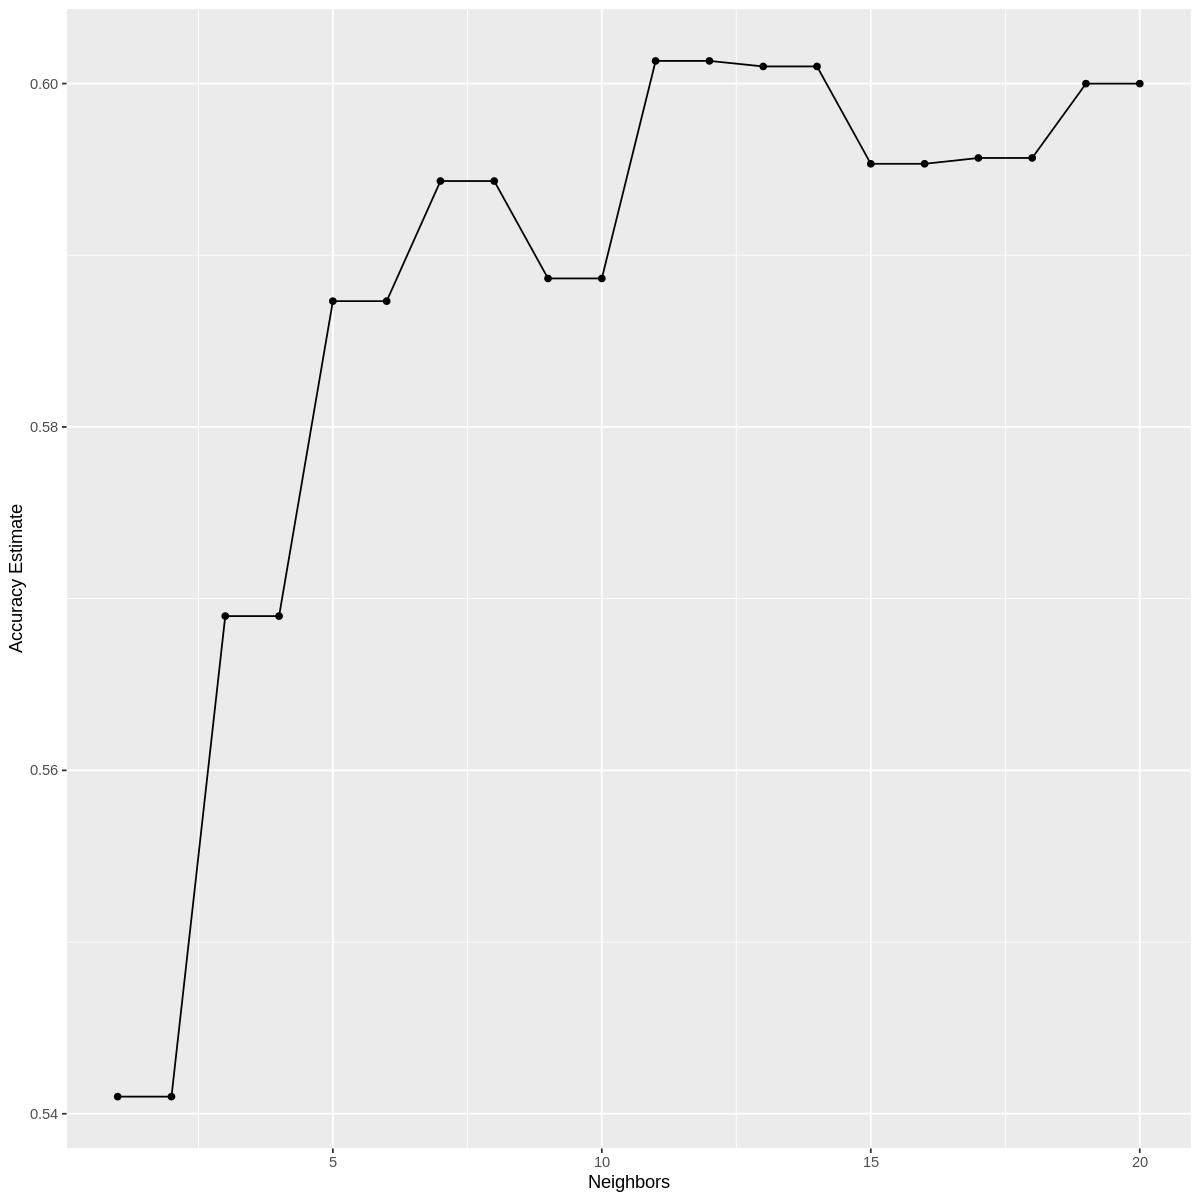

In [6]:
accuracies<-apple_results |>
 filter(.metric == "accuracy")

options(repr.plot.height = 10, repr.plot.width = 10)

accuracies_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
 geom_point() +
 geom_line() +
 labs(x = "Neighbors", y = "Accuracy Estimate")
accuracies_k

### Creating the Final Model ###

With the K value chosen, we can now create the final model that will be making the actual predictions on quality based on the variables that we have chosen.

In [7]:
# We now create the new model with this selected K Value

set.seed(4321)

apple_vfold<- vfold_cv(apple_train, v=5, strata=quality)

apple_recipe_final <- recipe(quality ~ ripeness + acidity, data = apple_train) |>
 step_scale(all_predictors())|>
 step_center(all_predictors())

apple_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
         set_engine("kknn") |>
         set_mode("classification")

apple_fit <- workflow() |>
    add_recipe(apple_recipe_final) |>
    add_model(apple_spec_final) |>
    fit(data = apple_select)

apple_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.392
Best kernel: rectangular
Best k: 11

### Using the Model to Predict Quality ###
Now that we have created our finalized classification model, with a defind K value, we will now use that model to make sample predictions on the quality of an apple, given any value for both acidity and ripeness.

In [8]:
apple_prediction_1 <- tibble(ripeness = 1.11, acidity = 1.11)
apple_prediction_2 <- tibble(ripeness = 0.51, acidity = 0.61)
apple_prediction_3 <- tibble(ripeness = 1.01, acidity = 0.91)
apple_prediction_4 <- tibble(ripeness = -0.123, acidity = -0.123)
apple_prediction_5 <- tibble(ripeness = 2.5, acidity = -1.5)

# For this example, we will use the apple_prediction_1 (You can create your own random observations or pull some to demonstrate)
apple_predicted <- predict(apple_fit, apple_prediction_1)
apple_predicted

.pred_class
<fct>
good


In [9]:
# Sample Prediction 2

apple_predicted_2 <- predict(apple_fit, apple_prediction_2)
apple_predicted_2

.pred_class
<fct>
bad


In [10]:
# Sample Prediction (From the firt observation of apple_select)

apple_prediction_ds_0 <- tibble(ripeness = 0.32983980, acidity = -0.4915905)

apple_predicted_ds_0 <- predict(apple_fit, apple_prediction_ds_0)
apple_predicted_ds_0

# Bonus: From what we can see the predictions match!. You can continue on and try different values. These 3 were for demonstration that our model works!

.pred_class
<fct>
good


In [11]:
## BLANK CELL